Saving datos_ventas_inf.csv to datos_ventas_inf.csv


Se truncaron las últimas líneas 5000 del resultado de transmisión.
 'value__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)'
 'value__spkt_welch_density__coeff_8'
 'value__ar_coefficient__coeff_0__k_10'
 'value__ar_coefficient__coeff_1__k_10'
 'value__ar_coefficient__coeff_2__k_10'
 'value__ar_coefficient__coeff_3__k_10'
 'value__ar_coefficient__coeff_4__k_10'
 'value__ar_coefficient__coeff_5__k_10'
 'value__ar_coefficient__coeff_6__k_10'
 'value__ar_coefficient__coeff_7__k_10'
 'value__ar_coefficient__coeff_8__k_10'
 'value__ar_coefficient__coeff_9__k_10'
 'value__fft_coefficient__attr_"real"__coeff_7'
 'value__fft_coefficient__attr_"real"__coeff_8'
 'value__fft_coefficient__attr_"real"__coeff_9'
 'value__fft_coefficient__attr_"real"__coeff_10'
 'value__fft_coefficient__attr_"real"__coeff_11'
 'value__fft_coefficient__attr_"real"__coeff_12'
 'value__fft_coefficient__attr_"real"__coeff_13'
 'value__fft_coefficient__attr_"real"__coeff_14'
 'value__fft_coefficient__attr_"real"__c

Número de observaciones: 43
Número de features: 783
MAE: 86539.31
RMSE: 102798.75
MAPE: 10.27%
BIAS: -53445.88 unidades
Número total de features: 783
Número de features seleccionados: 0
X original: (43, 783)
X seleccionados: (43, 0)


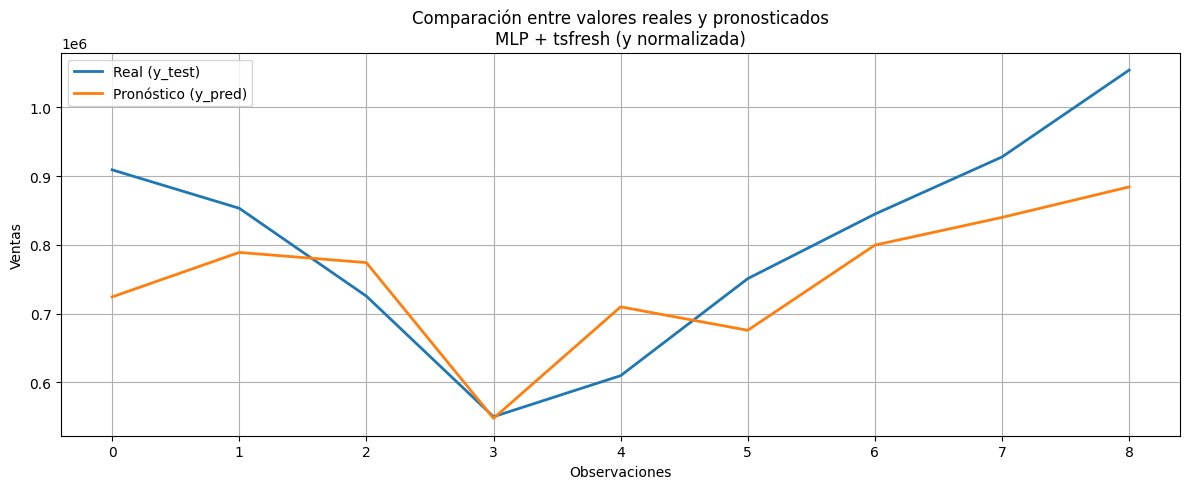

In [ ]:
# Instalar tsfresh (solo una vez por sesión)
!pip install tsfresh
# Subir tu archivo CSV
from google.colab import files
uploaded = files.upload()
# Cargar los datos
import pandas as pd

df = pd.read_csv('datos_ventas_inf.csv', parse_dates=['fecha'])

# Verificar columnas y contenido
df.columns = df.columns.str.strip()  # Limpiar espacios si hay
df = df[['fecha', 'venta']]  # Usamos solo lo necesario por ahora
df = df.sort_values('fecha')  # Ordenamos por fecha
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

def crear_dataset_tsfresh(df, ventana=12):
    """
    Genera dataset para pronóstico usando tsfresh sobre ventanas móviles.
    """
    X_total = []
    y_total = []

    for i in range(len(df) - ventana - 1):
        df_ventana = df.iloc[i:i+ventana].copy()
        df_ventana = df_ventana.rename(columns={'fecha': 'time', 'venta': 'value'})
        df_ventana['id'] = 1

        # Extraer features automáticos
        features = extract_features(
            df_ventana[['id', 'time', 'value']],
            column_id='id',
            column_sort='time',
            disable_progressbar=True
        )
        features = impute(features)

        # Target: la venta del período siguiente
        X_total.append(features.iloc[0])
        y_total.append(df.iloc[i + ventana]['venta'])

    # Armar X e y finales
    X_final = pd.DataFrame(X_total).reset_index(drop=True)
    y_final = pd.Series(y_total).reset_index(drop=True)

    return X_final, y_final

# Aplicamos la función con ventana de 12 períodos (ej. meses)
X, y = crear_dataset_tsfresh(df, ventana=12)

# Verificamos tamaño y estructura
print(f"Número de observaciones: {X.shape[0]}")
print(f"Número de features: {X.shape[1]}")
X.head()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Escaladores para X e y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalizamos X
X_scaled = scaler_X.fit_transform(X)

# Normalizamos y (necesitamos reshape para sklearn)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Dividimos (sin mezclar porque es serie temporal)
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train_scaled)

# Predicción sobre y escalada
y_pred_scaled = mlp.predict(X_test)

# Desescalamos para volver a la escala real
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAPE y BIAS
non_zero = y_test != 0
mape = np.mean(np.abs((y_test[non_zero] - y_pred[non_zero]) / y_test[non_zero])) * 100
bias = np.mean(y_pred - y_test)

print(f"MAPE: {mape:.2f}%")
print(f"BIAS: {bias:.2f} unidades")


# Desnormalización del conjunto de test y las predicciones
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

X = impute(X)
X_selected = select_features(X, y)

print(f"Número total de features: {X.shape[1]}")
print(f"Número de features seleccionados: {X_selected.shape[1]}")
print(f"X original: {X.shape}")
print(f"X seleccionados: {X_selected.shape}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Real (y_test)', linewidth=2)
plt.plot(y_pred, label='Pronóstico (y_pred)', linewidth=2)
plt.title('Comparación entre valores reales y pronosticados\nMLP + tsfresh (y normalizada)')
plt.xlabel('Observaciones')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
